In [275]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import shuffle
%matplotlib inline

# Data Cleaning

From our data exploration before, we know there are a number of missing data points in a couple different columns

In [278]:
df = pd.read_csv("train_ctrUa4K.csv")

In [279]:
df.apply(lambda x: sum(x.isnull()), axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Compared to our overall amount of data, there aren't that many missing values. However, this is only accounting for all the Null values. There may also exist values in our data that don't make sense and we'll have to identify and deal with those as well.

### Cleaning Loan Amount Null Values

We can try to use the relationship between loan amount and other variables to determine an effective way to fill in the missing values. (Overkill would be to develop a supervised learning model to do this task).

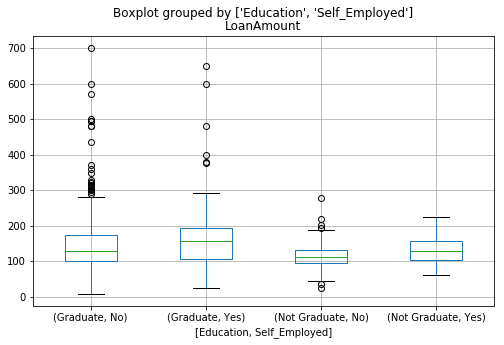

In [280]:
df.boxplot(column='LoanAmount', by=['Education', 'Self_Employed'], figsize=(8,5))

Since there exists differences in the median between these 4 groups, we can use this median to fill in the values of Loan Amount. However, there are missing values in the Self Employed column, so we have to deal with those first.

In [281]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [282]:
500/582

0.8591065292096219

There is an 86% chance that a person in this data is not self employed, so it's a safe assumption that at least most of these missing values are No.

In [283]:
df['Self_Employed'].fillna('No',inplace=True)

In [284]:
table = df.pivot_table(values='LoanAmount', index='Self_Employed', columns='Education', aggfunc=np.median)
table

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


In [285]:
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(lambda x: table.loc[x['Self_Employed'], x['Education']], axis=1), inplace=True)

In [286]:
assert df['LoanAmount'].isnull().sum() == 0

If the assertion passes, then we have dealt with all null values in Loan Amount.

### Dealing With Extreme Values in Distribution of LoanAmount

Since the extreme values are practically possible, i.e. some people might apply for high value loans due to specific needs. So instead of treating them as outliers, let’s try a log transformation to nullify their effect.

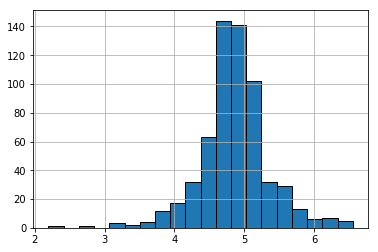

In [287]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20, ec='k')

The distribution has been standardized a bit and looks closer to the normal distribution, thus reducing the effect of the extreme values.

### Gender Null Values

In [288]:
df['Gender'].value_counts(dropna=False)

Male      489
Female    112
NaN        13
Name: Gender, dtype: int64

There are 13 missing Gender values. Some possible approaches include
- Explore relationships between gender and other variables and use that relationship to draw conclusions.
- Find the ratio of men to women in the dataset and fill in the NaN values in such a way that we keep the same ratio
- Make all the NaN values Male since they are the most popular of the two choices in the dataset
- Drop the null values

In [289]:
df[df['Gender'] == 'Male'].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_log
count,489.000000,489.000000,489.000000,478.000000,451.000000,489.000000
mean,5446.460123,1742.932352,148.421268,339.665272,0.847007,4.883623
std,6185.789262,2606.507054,81.331047,67.089140,0.360381,0.478912
min,150.000000,0.000000,17.000000,12.000000,0.000000,2.833213
25%,2917.000000,0.000000,104.000000,360.000000,1.000000,4.644391
50%,3865.000000,1430.000000,130.000000,360.000000,1.000000,4.867534
75%,5923.000000,2436.000000,172.000000,360.000000,1.000000,5.147494
max,81000.000000,33837.000000,650.000000,480.000000,1.000000,6.476972


In [290]:
df[df['Gender'] == 'Female'].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_log
count,112.000000,112.000000,112.000000,109.000000,101.000000,112.000000
mean,4643.473214,1108.008929,126.879464,352.293578,0.831683,4.707681
std,3585.381488,4094.595514,78.273523,56.722081,0.376013,0.529347
min,210.000000,0.000000,9.000000,36.000000,0.000000,2.197225
25%,2661.500000,0.000000,89.500000,360.000000,1.000000,4.494191
50%,3583.000000,0.000000,113.000000,360.000000,1.000000,4.727388
75%,4606.500000,1635.000000,138.000000,360.000000,1.000000,4.927254
max,19484.000000,41667.000000,600.000000,480.000000,1.000000,6.396930


There is a significant difference between the median Coapplicant Income for men when compared to women. So let's investigate this value further.

In [291]:
Male_coapp = df[df['Gender'] == 'Male']['CoapplicantIncome']
Male_coapp.value_counts()[0]/len(Male_coapp) # Ratio of males with 0 Coapp Income

0.39059304703476483

In [292]:
Female_coapp = df[df['Gender'] == 'Female']['CoapplicantIncome']
Female_coapp.value_counts()[0]/len(Female_coapp)

0.6785714285714286

About 39% of men have 0 Coapp income and about 68% of women have 0 Coapp income. So we'll use this metric to help us decide

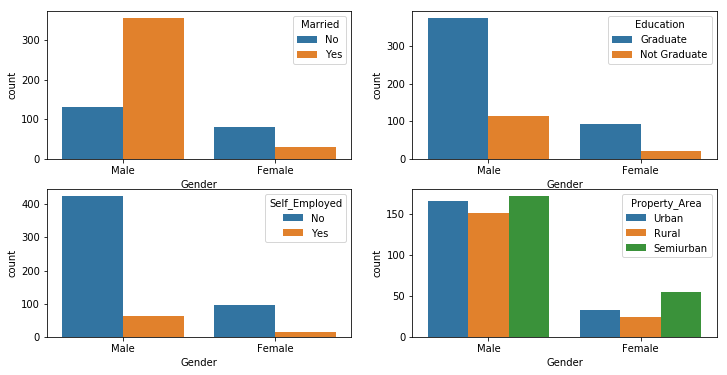

<Figure size 864x504 with 0 Axes>

In [293]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
plt.figure(figsize=(12,7))
sns.countplot(x='Gender', hue='Married', data=df, ax=ax[0,0])
sns.countplot(x='Gender', hue='Education', data=df, ax=ax[0,1])
sns.countplot(x='Gender', hue='Self_Employed', data=df, ax=ax[1,0])
sns.countplot(x='Gender', hue='Property_Area', data=df, ax=ax[1,1])

From these charts we can gather that the men in this dataset are more likely to be married, which explains why they are more likely to have a Coapplicant Income

In [294]:
print('Married')
print(df[(df['Married'] == 'Yes')]['Gender'].value_counts())
print('\nMarried and 0 coapplicant income')
print(df[(df['Married'] == 'Yes') & (df['CoapplicantIncome'] == 0)]['Gender'].value_counts())

Married
Male      357
Female     31
Name: Gender, dtype: int64

Married and 0 coapplicant income
Male      113
Female     12
Name: Gender, dtype: int64


In [295]:
print('Ratio of married men with 0 coapp income ')
print(113/357)
print('\nRatio of married women with 0 coapp income ')
print(12/31)

Ratio of married men with 0 coapp income 
0.3165266106442577

Ratio of married women with 0 coapp income 
0.3870967741935484


- In the end there wasn't conclusive evidence that these traits can be used to determine Gender. The relationship might've been there due to sampling bias.
- I'll just randomly assign women and men to NaN values in such a way that i keep the same ratio.

In [296]:
pct_women = len(Female_coapp)/len(df.dropna(subset=['Gender'])) # Percentage of women in the dataset 
num_women = round(13*pct_women)

In [297]:
missing_genders = ['Female']*num_women + ['Male']*(13-num_women)
missing_genders

['Female',
 'Female',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male',
 'Male']

In [298]:
shuffle(missing_genders)

In [299]:
df.loc[df['Gender'].isna(), 'Gender'] = missing_genders

In [300]:
assert not any(df.Gender.isna())

### Married Null Values

There are only 2 here, so dropping them won't cause any major repercussions

In [301]:
df.dropna(subset=['Married'], inplace=True)

In [302]:
assert not any(df.Married.isna())

### Dependents Null Values

In [303]:
df['Dependents'].value_counts(dropna=False)

0      345
1      102
2      101
3+      51
NaN     12
Name: Dependents, dtype: int64

A good place to start looking is the relationship between dependents and marriage.

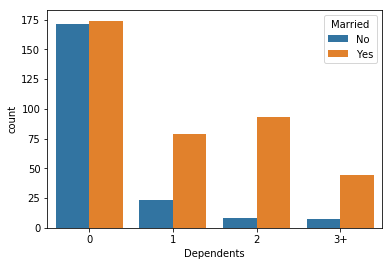

In [304]:
sns.countplot(x='Dependents', hue='Married', data=df)

As expected, most people that have dependencies are married. So, if they're not married, we can fill in their dependents as 0. However, if they are are married we have to look at other ways of determining dependents

In [305]:
not_married = df[df['Dependents'].isna()].Married.value_counts()[1]

In [306]:
df.loc[(df['Dependents'].isna()) & (df['Married'] == 'No'), 'Dependents'] = (['0']*not_married)

With the given information it's tough to tell whether 

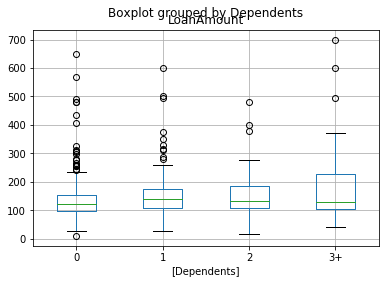

In [307]:
df.boxplot(column='LoanAmount', by=['Dependents'])

In [308]:
df[['Dependents', 'Credit_History']].groupby('Dependents').mean()

,Credit_History
Dependents,
0,0.853125
1,0.844444
2,0.852632
3+,0.770833


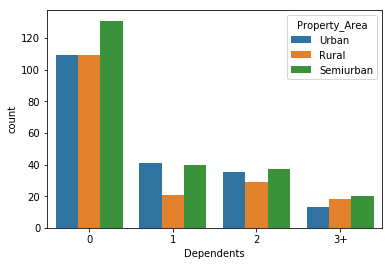

In [309]:
sns.countplot(x='Dependents', hue='Property_Area', data=df)

There doesn't seem to be any clear cut way to differentiate people with 1-3 dependents. So now I have a choice between dropping the values or changing them to be the most popular (0). However, I don't want to introduce new values without evidence to back it up so i'll drop the values

In [310]:
df.dropna(subset=['Dependents'], inplace=True)

In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 0 to 613
Data columns (total 14 columns):
Loan_ID              603 non-null object
Gender               603 non-null object
Married              603 non-null object
Dependents           603 non-null object
Education            603 non-null object
Self_Employed        603 non-null object
ApplicantIncome      603 non-null int64
CoapplicantIncome    603 non-null float64
LoanAmount           603 non-null float64
Loan_Amount_Term     590 non-null float64
Credit_History       553 non-null float64
Property_Area        603 non-null object
Loan_Status          603 non-null object
LoanAmount_log       603 non-null float64
dtypes: float64(5), int64(1), object(8)
memory usage: 70.7+ KB
